In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Read the dataset
df = pd.read_csv('Datasets/Cancer_Data.csv')

In [6]:
# Basic EDA
print("\nDataset Shape:", df.shape)
print("\nValue counts of diagnosis:")
print(df['diagnosis'].value_counts())

# Drop ID column as it's not needed for analysis
df = df.drop('id', axis=1)

# Convert diagnosis to binary (M=1, B=0)
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})


Dataset Shape: (569, 33)

Value counts of diagnosis:
diagnosis
B    357
M    212
Name: count, dtype: int64


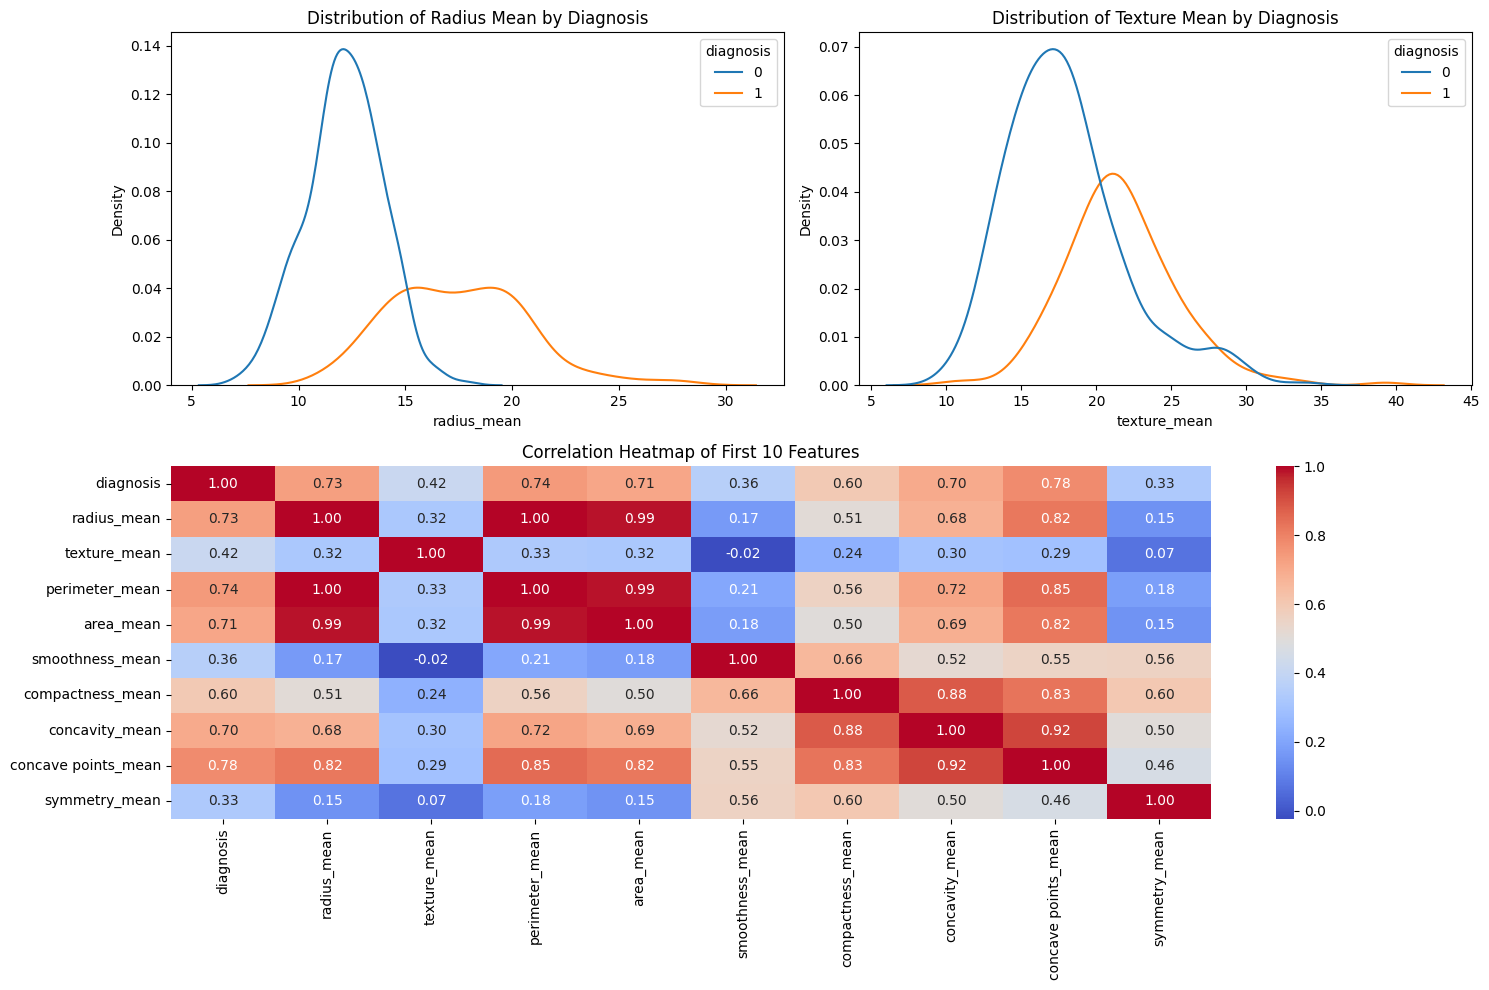

In [7]:
# Create figure for EDA visualizations
plt.figure(figsize=(15, 10))

# Distribution plot of radius_mean by diagnosis
plt.subplot(2, 2, 1)
sns.kdeplot(data=df, x='radius_mean', hue='diagnosis')
plt.title('Distribution of Radius Mean by Diagnosis')

# Distribution plot of texture_mean by diagnosis
plt.subplot(2, 2, 2)
sns.kdeplot(data=df, x='texture_mean', hue='diagnosis')
plt.title('Distribution of Texture Mean by Diagnosis')

# Correlation heatmap of first 10 features
plt.subplot(2, 2, (3,4))
correlation_matrix = df.iloc[:, :10].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of First 10 Features')
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [9]:
# Create and train base SVM model
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)
base_accuracy = svm.score(X_test_scaled, y_test)
print("\nBase SVM Model Accuracy:", base_accuracy)


Base SVM Model Accuracy: 0.9824561403508771


In [10]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

In [11]:
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9758241758241759


In [12]:
# Train final model with best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)
y_pred = best_svm.predict(X_test_scaled)

In [13]:
# Calculate accuracy and create confusion matrix
final_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nFinal Model Accuracy:", final_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Final Model Accuracy: 0.9824561403508771

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



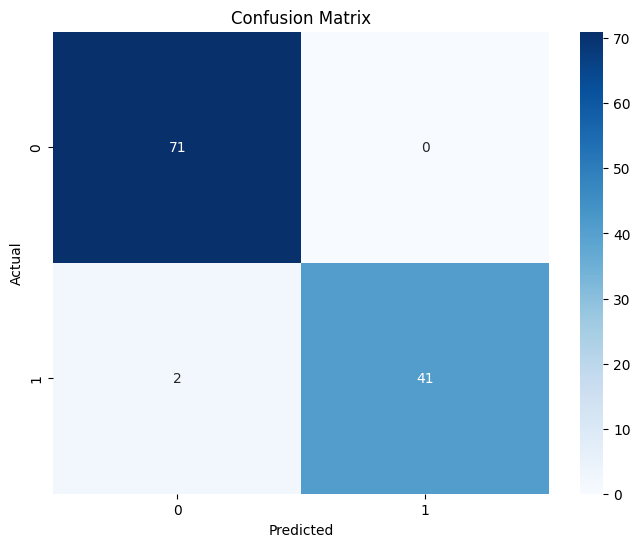

In [14]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

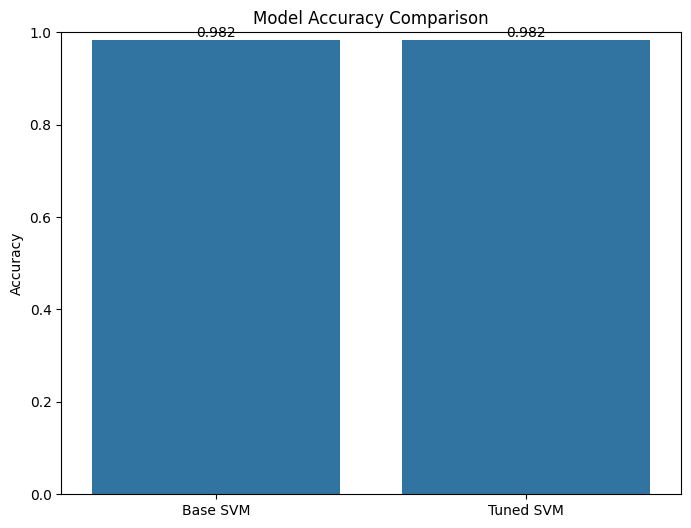

In [15]:
# Compare base model vs tuned model accuracy
models = ['Base SVM', 'Tuned SVM']
accuracies = [base_accuracy, final_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.3f}', ha='center', va='bottom')
plt.show()